# Predicting Manager Performance on Limited Data using Machine Learning Classification Algorithms

In this notebook, we apply various well known Machine Learning algorithms to a dataset of information about 600 managers in an organization to try to predict the performance of the managers.  The purpose of this is to demonstrate that prediction of work-related constructs such as job performance is usually poor across the board due to common inherent issues such as low sample size, poor class distribution and considerable noise caused by poor measurement on many of the constructs used to evaluate individuals.

It is common for laypeople in organizations, having read about the power of Machine Learning in other contexts, to believe that it can be applied to the prediction of work related constructs such as job performance.  This example should help demonstrate why this is unlikely to be successful and not a good use of analytic resource. 

First we load some immediate libraries.  We will load others later as we need them.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

Now we will load a dataset directly from Github provided by Keith McNulty.  Note McNulty provided this dataset as an example that could be used to learn explanatory analytic methods, not predictive methods.  This exercise will demonstrate the shortcoming of predictive methods on data of this nature.

In [3]:
manager_data = pd.read_csv('https://raw.githubusercontent.com/keithmcnulty/ebp_exercise/master/data.csv', 
                           index_col = 'employee_id')

Now we will take a brief look at the data.

In [4]:
manager_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, c4578853 to e81f635b
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   performance_group  571 non-null    object 
 1   yrs_employed       571 non-null    float64
 2   manager_hire       571 non-null    object 
 3   test_score         571 non-null    int64  
 4   group_size         571 non-null    int64  
 5   concern_flag       571 non-null    object 
 6   mobile_flag        571 non-null    object 
 7   customers          571 non-null    int64  
 8   high_hours_flag    571 non-null    object 
 9   transfers          571 non-null    int64  
 10  reduced_schedule   571 non-null    object 
 11  city               571 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 58.0+ KB


In [5]:
manager_data.head()

,performance_group,yrs_employed,manager_hire,test_score,group_size,concern_flag,mobile_flag,customers,high_hours_flag,transfers,reduced_schedule,city
employee_id,,,,,,,,,,,,
c4578853,Bottom,4.6,N,205,10,N,N,12,N,0,Y,San Francisco
a7d7afd6,Middle,5.3,N,227,14,N,Y,18,N,0,N,New York
272b93f1,Bottom,5.2,N,227,10,N,N,12,N,0,Y,Chicago
be8b6baa,Middle,4.9,N,273,19,N,N,26,Y,0,N,New York
a18ecc4e,Bottom,4.9,N,227,17,Y,N,26,Y,5,Y,Orlando


We notice that the data consists of 571 observations of managers, with numeric and categorical features, and is to some extent pre-processed.  If you would like to understand the features better, see [McNulty's repo](https://github.com/keithmcnulty/ebp_exercise).

`performance_group` is the field that we will be trying to predict.  Let's take a quick look at its values.

<AxesSubplot:xlabel='performance_group', ylabel='count'>

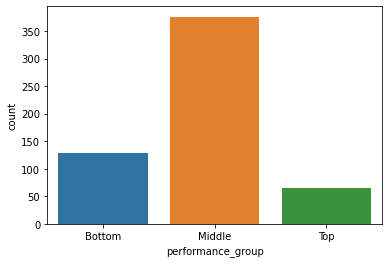

In [6]:
sns.countplot(data = manager_data, x = "performance_group")

Here we have three performance categories, and as is typical with human ratings, there is a considerable degree of central tendency bias with around two-thirds of all ratings taking the middle category.

To keep our classification problem simple, let's choose to predict one category.  In any Machine Learning problem, class imbalance can cause a challenge, and so for this reason lets choose to predict the Bottom performers.  Approximately 20% of the sample will therefore be in the positive class, and about 80% will be in the negative class.  Algorithms will learn quickly that, all else being equal, predicting negative will give the best chance of success, therefore we will be interested in algorithm that are 'braver' and more successful in predicting the minority of positive classes.

Let's transform our data so that our target is a simple binary classification of 'Bottom' or 'Not Bottom'.

In [7]:
## convert to binary bottom
binary_bottom = pd.get_dummies(manager_data['performance_group'])['Bottom']
binary_bottom.columns = 'Bottom'

In [8]:
manager_data_bot = pd.concat([manager_data.drop('performance_group', axis = 1), binary_bottom], axis = 1)

Now, a number of our input features are categorical, so we will need to transform these into dummy variables for learning purposes.  

In [9]:
## get dummies
dummy_vars = ['manager_hire', 'concern_flag', 
             'mobile_flag', 'high_hours_flag', 
             'reduced_schedule', 'city']

dummies = pd.get_dummies(manager_data_bot[dummy_vars], 
                         drop_first=True)


In [10]:
data = pd.concat([manager_data_bot.drop(dummy_vars, axis = 1), dummies], axis = 1)

Now that we have transformed our data to prepare for the learning process, let's split it into an object for inputs and an object for outputs, and take a quick look at these.

In [11]:
X = data.drop('Bottom', axis = 1)
y = data['Bottom']
X.head()

,yrs_employed,test_score,group_size,customers,transfers,manager_hire_Y,concern_flag_Y,mobile_flag_Y,high_hours_flag_Y,reduced_schedule_Y,city_Houston,city_New York,city_Orlando,city_San Francisco,city_Toronto
employee_id,,,,,,,,,,,,,,,
c4578853,4.6,205,10,12,0,0,0,0,0,1,0,0,0,1,0
a7d7afd6,5.3,227,14,18,0,0,0,1,0,0,0,1,0,0,0
272b93f1,5.2,227,10,12,0,0,0,0,0,1,0,0,0,0,0
be8b6baa,4.9,273,19,26,0,0,0,0,1,0,0,1,0,0,0
a18ecc4e,4.9,227,17,26,5,0,1,0,1,1,0,0,1,0,0


In [12]:
y.head()

employee_id
c4578853    1
a7d7afd6    0
272b93f1    1
be8b6baa    0
a18ecc4e    1
Name: Bottom, dtype: uint8

Our features and our target look good.  So we can proceed.  First we will try to use a simple logistic regression model to predict Bottom performers.

## Logistic Regression Model

For more on the mathematics underlying Logistic Regression, see Section 4.3 of [An Introduction to Statistical Learning](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf).  

We import our model, and divide our sets into training and testing sets using a 70/30 split.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

Now we create and fit a model to the training data.  Note that for Logistic Regression model we do not need to worry about scaling the features.

In [15]:
model = LogisticRegression(max_iter=1000)

In [16]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Now we use our fitted model to predict the performance of the test set.

In [17]:
predicts = model.predict(X_test)

We can now compare the predicted performance of the test set to the actual performance and generate a confusion matrix and a classification report.

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
print(confusion_matrix(y_test, predicts))

[[128   2]
 [ 40   2]]


As we can see, the model is very shy to predict anyone in the Bottom performance group. The right hand colum tells us that of the four people it did predict to be Bottom performance, two of them were Bottom performers.  However there were forty other Bottom performers that it did not predict correctly.

Let's look at a classification report.

In [20]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       130
           1       0.50      0.05      0.09        42

    accuracy                           0.76       172
   macro avg       0.63      0.52      0.47       172
weighted avg       0.70      0.76      0.67       172



This is not great - but we have used the default threshold of a 0.5 probability to classify our positive class.  Could we achieve a better classification if we were to move this threshold downwards?

First let's get our classification probabilities for the test set.

In [21]:
probs_y=model.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first 
  # column of 
  # array) vs 1 (2nd column in array)

Now let's look at the precision and recall curves.

(0.0, 1.0)

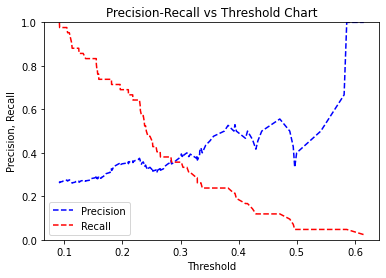

In [22]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

It seems that we might do better on recall setting a substantially lower threshold.  Let's try 0.23.

In [34]:
predicts_new = probs_y[:,1] > 0.23

In [35]:
print(confusion_matrix(y_test, predicts_new))

[[85 45]
 [16 26]]


In [38]:
print(classification_report(y_test, predicts_new))

              precision    recall  f1-score   support

           0       0.84      0.65      0.74       130
           1       0.37      0.62      0.46        42

    accuracy                           0.65       172
   macro avg       0.60      0.64      0.60       172
weighted avg       0.73      0.65      0.67       172



Because of this adjustment we can now correctly identify 26 of our 42 Bottom performers in the test set.  However, in lowering the threshold we are also encouraging the model to be braver in selecting the positive class - moving from 4 to 71 positive predictions and resulting in 45 false positives. This trade-off is important.  So although the model predicts the majority of the positive class, this is only a minority of the positive predictions.  

## Naive Bayes Classifier

Current Naive Bayes implementations assume either normal, multinomial or Bernoulli distribituons.  Given our input features are both real and binary, none of these would apply, so we will skip this algorithm.  There has been some discussion on implementing a mixed normal/Bernoulli Naive Bayes Classifier in `scikit-learn` in the future, which would suit this model.


## K-Nearest Neighbours 

We will now try to predict Bottom performers by using an algorithm that tries to identify people with similar features and predict on the basis of how many of those are Bottom performers.  For more on the mathematics underlying K Nearest Neighbours, see page 39 of An Introduction to Statistical Learning.

For subsequent methods we will need to scale our input data, which we will do using a Standard Scaler.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [21]:
X_train = scaler.fit_transform(X_train)

In [22]:
X_test = scaler.transform(X_test)

First we will need to find the best value of K, and we can do this using the elbow method.  We try several consecutive values of K and calculate the prediction error for each.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

for i in range(1, 40):
    modeli = KNeighborsClassifier(n_neighbors=i)
    modeli.fit(X_train, y_train)
    predicti = modeli.predict(X_test)
    error_rate.append(np.mean(predicti != y_test))

In [24]:
error_rate = pd.DataFrame(dict(k=range(1,40), err=error_rate))

Now we plot the errors.

<AxesSubplot:xlabel='k', ylabel='err'>

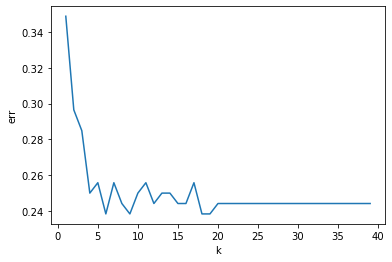

In [25]:
sns.lineplot(data = error_rate, x = 'k', y = 'err')

k = 6 look like an early error minimizer.

In [26]:
knnmodel = KNeighborsClassifier(n_neighbors=6)

Now we can fit and measure our model as before.

In [27]:
knnmodel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [28]:
knnpredicts = knnmodel.predict(X_test)

In [29]:
print(confusion_matrix(y_test, knnpredicts))

[[126   4]
 [ 37   5]]


This model is shy to predict positive. It suggests nine people as Bottom performers and is accurate for more than half.  It still misses 37 of them though.

In [30]:
print(classification_report(y_test, knnpredicts))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       130
           1       0.56      0.12      0.20        42

    accuracy                           0.76       172
   macro avg       0.66      0.54      0.53       172
weighted avg       0.72      0.76      0.70       172



## Basic Decision Tree

We will now apply a Decision Tree model to our data.  For more on Decision Trees see Section 8.1 of An Introduction to Statistical Learning.

We will take an identical approach by setting up our model, fitting it and measuring the results.

In [31]:
from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier()

In [32]:
treemodel.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
treepredicts = treemodel.predict(X_test)

In [34]:
print(confusion_matrix(y_test, treepredicts))

[[99 31]
 [26 16]]


This model is much happier to classify positive classes, identifying 47 individuals as being potential Bottom performers.  However it is accurate in about 30% of them.  If you are trying to achieve a better trade off between true positives and false positives, this model may be better than our tweaked logistic model.

In [35]:
print(classification_report(y_test, treepredicts))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       130
           1       0.34      0.38      0.36        42

    accuracy                           0.67       172
   macro avg       0.57      0.57      0.57       172
weighted avg       0.68      0.67      0.67       172



## Random Forest 

Random Forest algorithms construct numerous decision trees and output the mode of the classes from each.  For more information, see Section 8.2 of An Introduction to Statistical Learning. 

Given the imbalance in this dataset, splitting it into too many trees will only serve to increase the bias to classify inputs as negative.  We could try with a single tree.

In [36]:
from sklearn.ensemble import RandomForestClassifier
forestmodel = RandomForestClassifier(n_estimators = 1)

In [37]:
forestmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1)

In [38]:
forestpredicts = forestmodel.predict(X_test)

In [39]:
print((confusion_matrix(y_test, forestpredicts)))

[[103  27]
 [ 25  17]]


It has a slightly better hit rate for Bottom performers, and in general seems to perform marginally better than a Basic Decision Tree.  If you experiment with greater numbers of trees you will find that it starts to bias heavily towards negative classification.

In [40]:
print((classification_report(y_test, forestpredicts)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       130
           1       0.39      0.40      0.40        42

    accuracy                           0.70       172
   macro avg       0.60      0.60      0.60       172
weighted avg       0.70      0.70      0.70       172



This is a better performing algorithm than the Basic Decision Tree, finding more true positives and fewer false positives.

## Support Vector Machines

We will now try a different type of classifier which uses linear algebra to plot each input in n-dimensional space and tries to find a 'separating hyperplane' to use to classify the data.  You can read more about this in Chapter 9 of An Introduction to Statistical Learning.

The best performance I could find from the Support Vector Classifier was where it used a 5th degree polynomial as its kernel.  

In [59]:
from sklearn.svm import SVC

In [60]:
svmmodel = SVC(kernel='poly', degree = 5)

In [61]:
svmmodel.fit(X_train, y_train)

SVC(degree=5, kernel='poly')

In [62]:
svmpredicts = svmmodel.predict(X_test)

In [63]:
print(confusion_matrix(y_test, svmpredicts))

[[122   8]
 [ 33   9]]


The model selected 17 Bottom performers and was correct in more than half.  Overall this performance is not as good as the prior Random Forest classifier, if your objective is the identification of Bottom performers.

In [64]:
print((classification_report(y_test, svmpredicts)))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       130
           1       0.53      0.21      0.31        42

    accuracy                           0.76       172
   macro avg       0.66      0.58      0.58       172
weighted avg       0.72      0.76      0.72       172



## Simple Artificial Neural Network

An Artificial Neural Network is really suited to complex learning tasks with large amounts of data.  It is very unlikely to be effective on such a small and chaotic dataset and will be very dificult not to overfit.  Nevertheless I include it here for reference.  

We use Tensorflow and Keras to train a simple Neural Network with an one hidden Dense layer, using fairly standard relu activation functions.  I didn't spend time parameter tuning here, as it wouldn't be worth the effort.

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [66]:
annmodel = Sequential()

# input layer
annmodel.add(Dense(15, activation='relu'))


# hidden layer
annmodel.add(Dense(5, activation='relu'))


# output layer
annmodel.add(Dense(units=1, activation='relu'))

# Compile model
annmodel.compile(loss='binary_crossentropy', optimizer='adam')

In [67]:
annmodel.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          validation_data=(X_test, y_test) 
          )

Epoch 1/25
13/13 [==============================] - 0s 14ms/step - loss: 1.6010 - val_loss: 2.1087
Epoch 2/25
13/13 [==============================] - 0s 5ms/step - loss: 1.4600 - val_loss: 2.0754
Epoch 3/25
13/13 [==============================] - 0s 4ms/step - loss: 1.4011 - val_loss: 1.9556
Epoch 4/25
13/13 [==============================] - 0s 4ms/step - loss: 1.3518 - val_loss: 1.9231
Epoch 5/25
13/13 [==============================] - 0s 4ms/step - loss: 1.3386 - val_loss: 1.9143
Epoch 6/25
13/13 [==============================] - 0s 4ms/step - loss: 1.3016 - val_loss: 1.8512
Epoch 7/25
13/13 [==============================] - 0s 5ms/step - loss: 1.2925 - val_loss: 1.8356
Epoch 8/25
13/13 [==============================] - 0s 4ms/step - loss: 1.2613 - val_loss: 1.7616
Epoch 9/25
13/13 [==============================] - 0s 4ms/step - loss: 1.1662 - val_loss: 1.6228
Epoch 10/25
13/13 [==============================] - 0s 4ms/step - loss: 1.0140 - val_loss: 1.4548
Epoch 11/25
13/13 

In [68]:
annpredicts = annmodel.predict_classes(X_test)

In [69]:
print(confusion_matrix(y_test, annpredicts))

[[123   7]
 [ 37   5]]


As expected, this did not perform well, and most likely overfit our data.

In [70]:
print(classification_report(y_test, annpredicts ))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       130
           1       0.42      0.12      0.19        42

    accuracy                           0.74       172
   macro avg       0.59      0.53      0.52       172
weighted avg       0.68      0.74      0.69       172



## XGBoost

Finally, we will use an XGBoost classifier which is a fairly novel, gradient boosted improvement on Decision Tree classifiers which has gotten a lot of attention and positive review from the ML community.  Similar to Random Forest, I also found that using a single tree (estimator) produced the best results in my opinion.

In [71]:
from xgboost import XGBClassifier

In [72]:
xgbmodel = XGBClassifier(n_estimators = 1)

In [73]:
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
xgbpredicts = xgbmodel.predict(X_test)

In [75]:
print(confusion_matrix(y_test, xgbpredicts))

[[120  10]
 [ 31  11]]


In [76]:
print(classification_report(y_test, xgbpredicts))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       130
           1       0.52      0.26      0.35        42

    accuracy                           0.76       172
   macro avg       0.66      0.59      0.60       172
weighted avg       0.73      0.76      0.73       172



This is is not as good as our Random Forest model in identifying Bottom performers.  It may benefit from some parameter tweaking.

## Conclusions

Of course, it's not the algorithms that are bad, it's the data. In general data on individuals in a workplace setting suffers from a number of issues, not least small samples (by ML standards) and class imbalance.  Our best performing algorithm (depending on your point of view) were either:

1.  A logistic regression model with a low threshold, which identified the majority of our Bottom performers but at the expense of a high number of false positives.

2.  A Random Forest classifier which was able to find 17 of the 42 Bottom performers in a test set of 172 individuals, with a substantially lower number of false positives compared to Logistic Regression.

None of these models are likely to garner trust in their predictions, as they are a long way away from the desired metrics for a predictive model that could be truested in practice.